In [1]:
!gdown https://drive.google.com/file/d/10OWo4v3Op1UQe_rCQX-laToo9wffIPIp/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=10OWo4v3Op1UQe_rCQX-laToo9wffIPIp
To: /content/vlsp_sentiment_test.csv
100% 159k/159k [00:00<00:00, 25.9MB/s]


In [2]:
!gdown https://drive.google.com/file/d/1CEC49GoeBrCBY3gTGoIFiW0YB5LOZXVb/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1CEC49GoeBrCBY3gTGoIFiW0YB5LOZXVb
To: /content/vlsp_sentiment_train.csv
100% 858k/858k [00:00<00:00, 116MB/s]


In [3]:
!gdown https://drive.google.com/file/d/1d4hk9wBL_MYr0_XACe_67LgCooQYrThl/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1d4hk9wBL_MYr0_XACe_67LgCooQYrThl
From (redirected): https://drive.google.com/uc?id=1d4hk9wBL_MYr0_XACe_67LgCooQYrThl&confirm=t&uuid=760261f6-a2e8-4f00-99de-612820723d23
To: /content/vi-model-CBOW.bin
100% 699M/699M [00:07<00:00, 95.4MB/s]


In [4]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils import to_categorical
%matplotlib inline

In [38]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [39]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [40]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [41]:
encoded_labels = []

for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [42]:
reviews_processed = []
unlabeled_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)

In [43]:
#Use PyVi for Vietnamese word tokenizer
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())


In [44]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [46]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index


In [47]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [48]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


In [49]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)


vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [33]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout,concatenate
from tensorflow.keras.layers import Reshape, Flatten,LSTM,GRU,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,5,7]
num_filters = 256
drop = 0.2

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

#sequence_length - filter_sizes[0] + 1
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)


merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1) #
merged_tensor = Bidirectional(GRU(512,activation = 'relu'))(merged_tensor)
flatten = Flatten()(merged_tensor)


#reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.02))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#,weight_decay = 2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='loss', min_delta=0.1, patience=4, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True, verbose=1)

# Combine callbacks into a list
callbacks_list = [model_checkpoint]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 400)             3167600   ['input_3[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 298, 256)             307456    ['embedding[2][0]']           
                                                                                                  
 conv1d_7 (Conv1D)           (None, 296, 256)             512256    ['embedding[2][0]']           
                                                                                            

In [34]:
model.fit(data, labels,  epochs=100, batch_size=512, callbacks=callbacks_list, shuffle=True) #validation_split=0.2,

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 11.0704 - accuracy: 0.3647
Epoch 1: loss improved from inf to 11.07038, saving model to best_model.h5
10/10 [==============================] - 9s 480ms/step - loss: 11.0704 - accuracy: 0.3647


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 7.0186 - accuracy: 0.4118
Epoch 2: loss improved from 11.07038 to 7.01863, saving model to best_model.h5
10/10 [==============================] - 5s 490ms/step - loss: 7.0186 - accuracy: 0.4118
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 4.8777 - accuracy: 0.6382
Epoch 3: loss improved from 7.01863 to 4.87768, saving model to best_model.h5
10/10 [==============================] - 5s 484ms/step - loss: 4.8777 - accuracy: 0.6382
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 3.3230 - accuracy: 0.7210
Epoch 4: loss improved from 4.87768 to 3.32304, saving model to best_model.h5
10/10 [==============================] - 5s 497ms/step - loss: 3.3230 - accuracy: 0.7210
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 2.2591 - accuracy: 0.7949
Epoch 5: loss improved from 3.32304 to 2.25914, saving model to best_model.h5
10/10 [==============================] -

In [50]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [51]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)

In [52]:
reviews_processed_test = []
unlabeled_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [53]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [54]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [57]:
print('Shape of X train and X validation tensor:',data_test.shape)
print('Shape of label train and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (1050, 300)
Shape of label train and validation tensor: (1050, 3)


In [58]:
score = model.evaluate(data_test, labels_test)

33/33 [==============================] - 1s 15ms/step - loss: 2.3404 - accuracy: 0.6790


In [59]:
print("%s: %.2f" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 234.04
accuracy: 67.90%


In [60]:
predictions = model.predict(data_test)

33/33 [==============================] - 1s 12ms/step


In [61]:
predictions = predictions.argmax(axis = 1 )

In [62]:
labels_test_class = labels_test.argmax(axis = 1 )

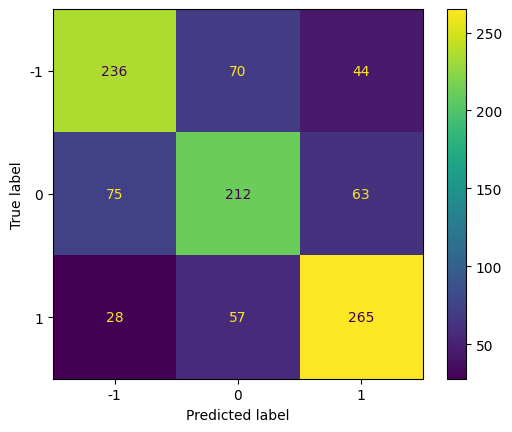

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mtrx = confusion_matrix(labels_test_class, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=mtrx,display_labels=[-1,0,1])
disp.plot()